# Apply PCM to argo reference data base

First try

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

from BIC_calculation import *

from classif_functions import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import argopy
argopy.set_options(src='localftp', local_ftp='/home/coriolis_exp/spool/co05/co0508/')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

import sys
np.set_printoptions(threshold=sys.maxsize)

### __User inputs__

Reference data selection

In [2]:
# geographical extent
geo_extent = [-70, -55, 35, 44] # [min lon, max lon, min lat, max lat]
# depth for interpolation
max_depth = 1000
# chose season ('DJF', 'MAM', 'JJA', 'SON' or 'all')
season = ['all']

Float you want to correct

In [3]:
float_WMO = 4900136

Model parameters

In [4]:
K=4 # number of classes

## 1. Load argo reference database and float data

__Load argo reference database__

In [5]:
ds = get_refdata(geo_extent=geo_extent, 
                 WMOboxes_latlon='WMO_boxes_latlon.txt', 
                 wmo_boxes='wmo_boxes_argo.mat', 
                 ref_path = '/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology/',
                 season = season)

/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology//argo_profiles/argo_7406.mat
291.818
299.952
/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology//argo_profiles/argo_7306.mat
290.00499725341797
299.989
/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology//argo_profiles/argo_7405.mat
300.00299072265625
309.996
/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology//argo_profiles/argo_7305.mat
300.003
309.9910011291504


In [ ]:
print(ds)

In [ ]:
np.mod((299.989+180),360)-180

In [ ]:
profile_depth = np.nanmax(ds['pres'], axis=0)
len(profile_depth[profile_depth<800])

__load float data__

In [6]:
ds = add_floatdata(float_WMO, ds)

In [7]:
print(ds)

<xarray.Dataset>
Dimensions:     (n_pres: 1049, n_profiles: 2379)
Coordinates:
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1043 1044 1045 1046 1047 1048
    long        (n_profiles) float64 -60.75 -60.63 -65.71 ... -51.06 -49.78
    lat         (n_profiles) float64 40.49 40.36 40.07 ... 38.12 38.8 38.67
    dates       (n_profiles) datetime64[ns] 2013-10-10T11:26:16 ... 2005-09-28T07:40:00
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 2373 2374 2375 2376 2377 2378
Data variables:
    pres        (n_pres, n_profiles) float64 1.0 1.0 5.4 5.3 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 23.43 21.57 26.01 ... nan nan nan
    sal         (n_pres, n_profiles) float64 35.65 35.87 36.15 ... nan nan nan
    source      (n_profiles) object '1901534_081.BRECKOWENS' ... 'selected_float'


plot dataset

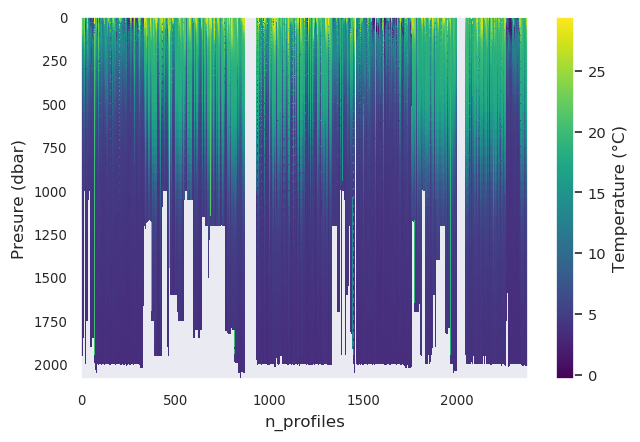

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(ds['n_profiles'], (len(ds['n_pres']),1)), ds['pres'], ds['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

In [9]:
print(np.nanmax(ds['pres']))
print(np.nanmin(ds['pres']))

2088.0
0.0


interpolate to standard levels

In [10]:
std_lev = np.arange(0,max_depth)
ds_out = interpolate_standard_levels(ds, std_lev)

In [11]:
# some format
#pres should be negative for the PCM
ds_out['PRES_INTERPOLATED'] = -np.abs(ds_out['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds_out.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_out.lat.attrs['axis'] = 'Y'
ds_out.long.attrs['axis'] = 'X'
ds_out.dates.attrs['axis'] = 'T'

In [12]:
print(ds_out)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 2225)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
    long               (n_profiles) float64 -60.75 -60.63 ... -51.06 -49.78
    lat                (n_profiles) float64 40.49 40.36 40.07 ... 38.8 38.67
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 2374 2375 2376 2377 2378
    dates              (n_profiles) datetime64[ns] 2013-10-10T11:26:16 ... 2005-09-28T07:40:00
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 1.0 1.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.65 ... 35.11
    source             (n_profiles) object '1901534_081.BRECKOWENS' ... 'selected_float'
    temp               (n_profiles, PRES_INTERPOLATED) float64 23.43 ... 7.723


some plots

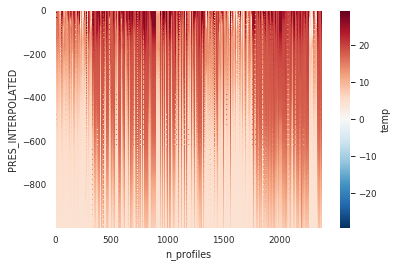

In [13]:
ds_out['temp'].plot(x='n_profiles');

In [ ]:
-55+9

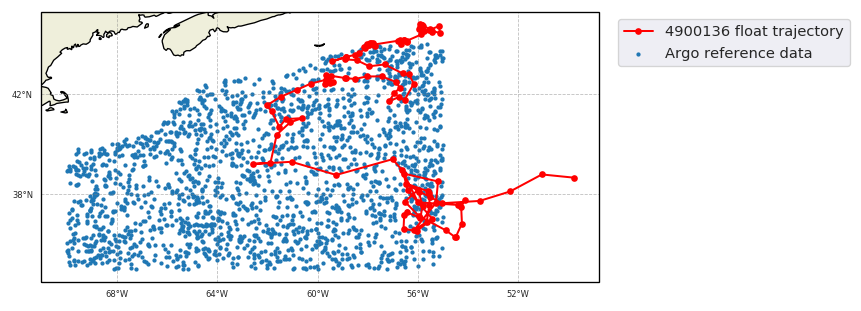

In [14]:
selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

p1 = ax.scatter(ds_out['long'], ds_out['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax.plot(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
                 'ro-', transform=proj, markersize = 3, label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## 2. Apply PCM

Create model

In [ ]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds_out[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

m = pcm(K=K, features=pcm_features)
m

Fit model

In [ ]:
var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

m.fit_predict(ds_out, features=features_in_ds, dim=z_dim, inplace=True)
m

In [ ]:
m.predict_proba(ds_out, features=features_in_ds, dim=z_dim, inplace=True);

In [ ]:
ds_out = ds_out.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[0], outname=var_name_ds[0] + '_Q', keep_attrs=True, inplace=True)
ds_out = ds_out.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[1], outname=var_name_ds[1] + '_Q', keep_attrs=True, inplace=True)

In [ ]:
print(ds_out)

## 3. BIC plot

User input

In [ ]:
corr_dist = 50 # correlation distance in km
time_steps = ['2018-01','2018-07']  # time steps to be used into account
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

BIC calculation __(not std for the moment)__

In [ ]:
BIC = []

select_prof = np.arange(0,len(ds_out.n_profiles.values),4)
ds_run = ds_out.isel(n_profiles = select_prof)
    
for i in range(1,NK):
    print(i)
    model = pcm(K=i, features=pcm_features)
    model.fit_predict(ds_run, features=features_in_ds, dim=z_dim)
    BIC.append(model.bic(ds_run, features=features_in_ds, dim=z_dim))
    
#BIC

BIC plot

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k')

ax.plot(np.arange(1,NK), BIC)
plt.ylabel('BIC')
plt.xlabel('Number of classes')
plt.xticks(np.arange(NK) + 1)
plt.title('Bayesian information criteria (BIC)')

print('BIC min: ' + str(np.argmin(BIC) + 1))

## 4. Plots

In [ ]:
P = Plotter(ds_out, m, coords_dict= {'latitude': 'lat', 'longitude': 'long', 'time': 'dates'})
P.data_type = 'profiles'

vertical structure

In [ ]:
P.vertical_structure(q_variable = var_name_ds[0] + '_Q', sharey=True, xlabel='Temperature (°C)')

In [ ]:
P.vertical_structure(q_variable = var_name_ds[1] + '_Q', sharey=True, xlabel='Salinity (PSU)', xlim=[32,37])

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds[0] + '_Q', plot_q= 'all', xlabel='Temperature (°C)')

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds[1] + '_Q', plot_q= 'all', xlabel='Salinity (PSU)')

spatial distribution

In [ ]:
P.spatial_distribution()

Classes pie chart

In [ ]:
P.pie_classes()

Temporal representation

Bar plot by month

In [ ]:
P.temporal_distribution(time_bins = 'month')

Bar plot by season

In [ ]:
P.temporal_distribution(time_bins = 'season')

## 4. Output

Create a .txt file with classes

In [ ]:
#create array with source, lat, long and PCM_labels
# change long values to 0-360 as used in OW
long_360 = np.mod(ds_out['long'].values, 360)
matrix_txt = np.stack((ds_out['source'].values, ds_out['lat'].values, long_360, ds_out['PCM_LABELS'].values), axis=1)
header = 'source lat long PCM_LABELS'

f= open("PCM_classes_NAtlac1_argo_LITTLE.txt","w+")
np.savetxt(f, matrix_txt, fmt=['%s', '%.3f', '%.3f', '%i'], header=header)
f.close() 

## 5. Plot with AVISO

Load AVISO data

In [ ]:
path_aviso = '/home1/homedir5/perso/agarciaj/EARISE/data/AVISO_gulfstream_2004.nc'
ds_aviso = xr.open_dataset(path_aviso)
ds_aviso

In [ ]:
ds_aviso['longitude'] = np.mod((ds_aviso.longitude.values+180),360)-180
ds_aviso

In [ ]:
time_step = '2004-09-03'

scatter plot using class

In [ ]:
selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

sc = ax.pcolormesh(ds_aviso['longitude'], ds_aviso['latitude'], ds_aviso['adt'].sel(time = time_step), cmap='bwr', transform=proj)
p1 = ax.scatter(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
                 s=8, c=ds_out['PCM_LABELS'].isel(n_profiles = selected_float_index), transform=proj, cmap='Accent')
#p2 = ax.scatter(ds_out['long'], ds_out['lat'], s=3, transform=proj, label='Argo reference data')
#p3 = ax.plot(ds_out['long'].isel(n_profiles = selected_float_index), ds_out['lat'].isel(n_profiles = selected_float_index), 
#                 'ro-', transform=proj, markersize = 3, label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 5}
gl.ylabel_style = {'fontsize': 5}
gl.xlabels_top = False
gl.ylabels_right = False

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim([-64,-48])
legend1 = ax.legend(*p1.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)